In [5]:
# Import libraries

from cil.framework import  AcquisitionGeometry
from cil.optimisation.algorithms import Algorithm
from cil.optimisation.functions import Function, L2NormSquared, BlockFunction, MixedL21Norm, IndicatorBox, LeastSquares, TotalVariation
from cil.optimisation.operators import GradientOperator, BlockOperator
from cil.optimisation.algorithms import PDHG
from cil.plugins.astra.operators import ProjectionOperator
# from cil.plugins.tigre import ProjectionOperator
from cil.plugins.astra.processors import FBP
from cil.plugins import TomoPhantom
from cil.utilities.display import show2D, show_geometry
from cil.utilities import noise
from cil.processors import Slicer

import matplotlib.pyplot as plt
import numpy as np
import importlib

In [6]:
# Custom imports
import sys
cil_path = '/u/s/cd902/GitHub/CIL/'
fun_path = 'Wrappers/Python/cil/optimisation/functions'
fista_path = 'Wrappers/Python/cil/optimisation/algorithms'
sys.path.append(cil_path + fun_path)
sys.path.append(cil_path + fista_path)
import SubsetSumFunction
from SubsetSumFunction import SAGAFunction
import FISTA
from FISTA import FISTA, ISTA, AdaptiveMomentumISTA

## Create dataset

/home/cd902/miniconda3/envs/cilnew/lib/python3.9/site-packages/cil/utilities/display.py:358: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(labels_new)


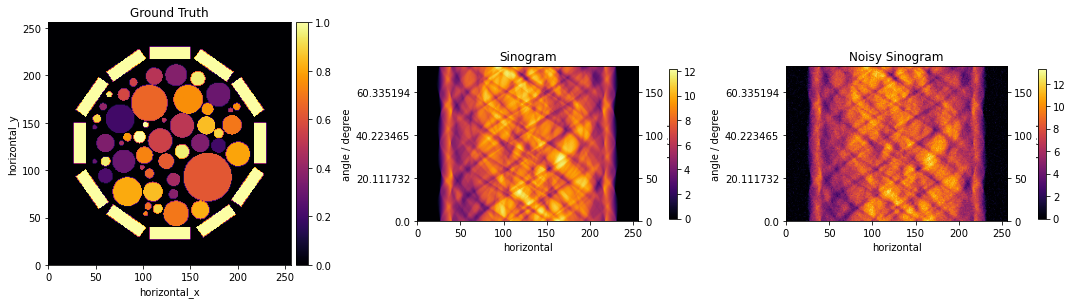

In [3]:
# Create dataset

# Detectors
N = 256
detectors =  N

# Angles
angles = np.linspace(0,180,180, dtype='float32')

# Define number of subsets
n_subsets = 10

# Setup acquisition geometry
ag = AcquisitionGeometry.create_Parallel2D()\
                        .set_angles(angles)\
                        .set_panel(detectors, pixel_size=0.1)
# Get image geometry
ig = ag.get_ImageGeometry()

# Get phantom
phantom = TomoPhantom.get_ImageData(12, ig)
# Create projection operator using Astra-Toolbox. Available CPU/CPU
A = ProjectionOperator(ig, ag, device = 'gpu')

# Create an acqusition data (numerically)
sino = A.direct(phantom)

# Simulate Gaussian noise for the sinogram
gaussian_var = 0.5
gaussian_mean = 0

n1 = np.random.normal(gaussian_mean, gaussian_var, size = ag.shape)
                      
noisy_sino = ag.allocate()
noisy_sino.fill(n1 + sino.array)
noisy_sino.array[noisy_sino.array<0]=0
# noisy_sino.fill(sino.array)

# Show numerical and noisy sinograms
show2D([phantom, sino, noisy_sino], title = ['Ground Truth','Sinogram','Noisy Sinogram'], num_cols=3, cmap = 'inferno')

# Initialize the lists containing the F_i's and A_i's
f_subsets = []
A_subsets = []

# Define F_i's and A_i's
for i in range(n_subsets):
    # Total number of angles
    n_angles = len(ag.angles)
    # Divide the data into subsets
    data_subset = Slicer(roi = {'angle' : (i,n_angles,n_subsets)})(noisy_sino)

    # Define A_i and put into list 
    ageom_subset = data_subset.geometry
    Ai = ProjectionOperator(ig, ageom_subset)
    A_subsets.append(Ai)

    # Define F_i and put into list
    fi = LeastSquares(Ai, b = data_subset)
    f_subsets.append(fi)


# Define F and K
F = BlockFunction(*f_subsets)


# Run ISTA, FISTA, SAGA and F-SAGA


In [7]:
num_epochs = 20
lb = 0.01
g = lb * TotalVariation(lower=0)
initial = ig.allocate(0)

# ISTA 
f_gd = 1/n_subsets * LeastSquares(A, noisy_sino)
step_size = 2*0.9 / f_gd.L
ista_tv = ISTA(initial=initial, f=f_gd, g=g,
                     step_size=step_size, update_objective_interval=1, 
                     max_iteration=1000)
ista_tv.run(num_epochs, verbose=0)

# FISTA
fista_tv = FISTA(initial=initial, f=f_gd, g=g,
                     update_objective_interval=1, 
                     max_iteration=1000)
fista_tv.run(num_epochs, verbose=0)

ISTA setting up
ISTA configured
Initialised GradientOperator with C backend running with  8  threads
FISTA setting up
FISTA configured


In [8]:
g = lb * TotalVariation(lower=0)
# SAGA
F_saga = SAGAFunction(F)
# admissible step-size is gamma = 1/ (3 max_i L_i)
step_size = 1 / (3*F_saga.Lmax)
F_saga.memory_reset()
saga_tv = ISTA(initial=initial, 
            f=F_saga,
            g=g,
            step_size=step_size, update_objective_interval=n_subsets, 
            max_iteration=10000)
saga_tv.run(num_epochs * n_subsets, verbose=0)

ISTA setting up
ISTA configured
Initialised GradientOperator with C backend running with  8  threads


In [9]:
# F-SAGA
F_saga = SAGAFunction(F)
F_saga.memory_reset()
# mini-batch size
b = 1
# step-size
def step_size_fun(k):
    return b**3 * (k + 4*n_subsets/b + 4) / (192 * n_subsets**2 * F_saga.Lmax)
# momentum
def momentum_fun(k):
    return b**3/ (96*n_subsets**1* F_saga.Lmax * step_size_fun(k))
fsaga_tv = AdaptiveMomentumISTA(initial=initial, 
            f=F_saga,
            g=g,
            step_size=step_size_fun, momentum=momentum_fun,
            update_objective_interval=n_subsets, 
            max_iteration=10000)
fsaga_tv.run(num_epochs * n_subsets, verbose=0)

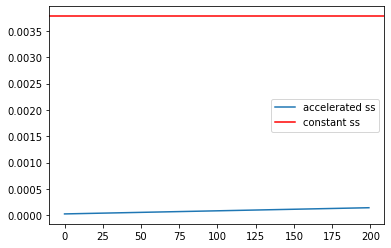

In [10]:
plt.figure(0)
kk = np.arange(num_epochs * n_subsets)
ss = step_size_fun(kk)
plt.plot(ss, label='accelerated ss')
plt.axhline(y=step_size, color='red', label='constant ss')
plt.legend()

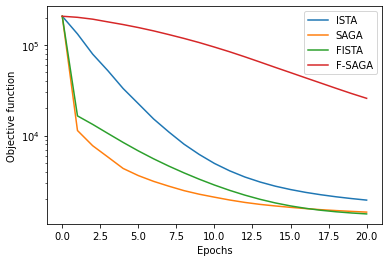

In [11]:
# compare results
plt.figure()
plt.semilogy(ista_tv.objective, label="ISTA")
plt.semilogy(saga_tv.objective, label="SAGA")
plt.semilogy(fista_tv.objective, label="FISTA")
plt.semilogy(fsaga_tv.objective, label="F-SAGA")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Objective function')
plt.show()

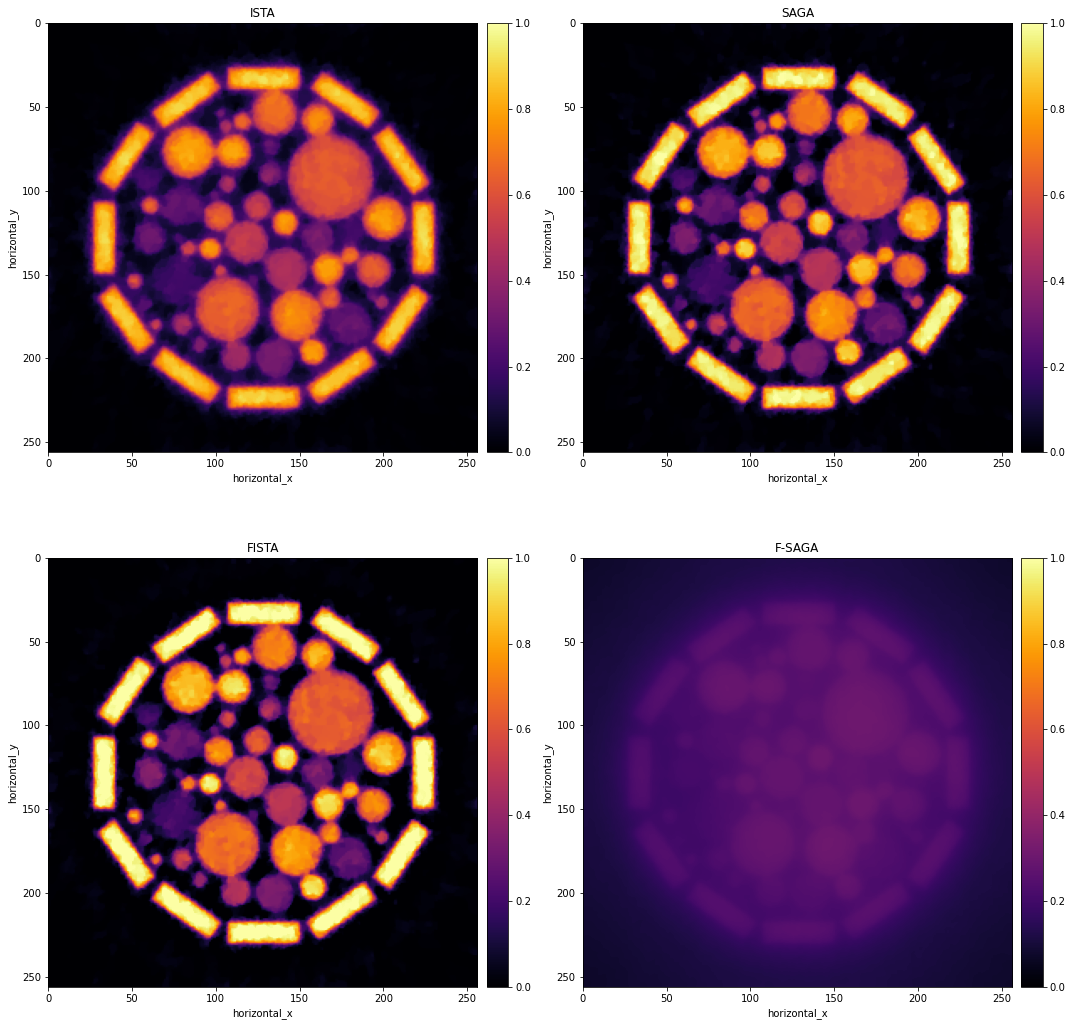

In [12]:
# Look at results
show2D([ista_tv.solution, saga_tv.solution, fista_tv.solution, fsaga_tv.solution], 
       origin="upper", 
       title=["ISTA","SAGA", "FISTA", "F-SAGA"],
       fix_range=(0,1), num_cols=2,
       cmap='inferno')